## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import string
import os
import numpy as np

import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Iterable
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [0]:
table = str.maketrans(dict.fromkeys(string.punctuation))
# уберем пунктуацию и заголовки (например, главы)
text = [line.translate(table) for line in text if len(line) > 10 ]

In [175]:
text[:10]

['  From fairest creatures we desire increase\n',
 '  That thereby beautys rose might never die\n',
 '  But as the riper should by time decease\n',
 '  His tender heir might bear his memory\n',
 '  But thou contracted to thine own bright eyes\n',
 '  Feedst thy lights flame with selfsubstantial fuel\n',
 '  Making a famine where abundance lies\n',
 '  Thy self thy foe to thy sweet self too cruel\n',
 '  Thou that art now the worlds fresh ornament\n',
 '  And only herald to the gaudy spring\n']

In [176]:
max([len(t) for t in text])

60

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [40]:
# # Join all the strings into one and lowercase it
# # Put result into variable text.

# # Your great code here

# text = ''.join(text).lower()
# print(len(text))
# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

100225
OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

Перед нами не стоит задача генерации слов, предложений, стоит задача сгенерировать текст заданной длины.  
Из-за этого во время обучения нашей сети нужно передавать больше одного предложения.  
Пусть мы решили обучать сеть на тексте длины `seq_len`.  
Я решил реализовать вариант, при котором один элемент батча представляет собой $k$ строк, идущих вподряд в исходном тексте, где $k$ максимальное такое, что если выбрать $k+1$ строку, то получится текст длины большей, чем `seq_len`. Дальше получившийся текст дополняется `pad` токеном до длины `seq_len`.  
Из-за подобной реализации пришлось немного иначе выполнить два пункта выше.  
Буду использовать свой кастомный словарь, `Dataset` и `Dataloader`.

In [0]:
class Vocabulary:
    '''
    Создает алфавит на основе переданного текста  
    Добавляет в алфавит служебный токен <pad> по умолчанию
    '''
    def __init__(self, 
                 special_tokens=['<pad>']):
        self.count = 0
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.special_tokens = special_tokens
        
    def fit(self, data):
        '''
        data : [line_1, ..., line_n] : list of strings
        Создает словарь по переданному тексту
        '''
        tokens = set(self.special_tokens)
        for line in data:
            tokens.update(set(line.lower()))
        self.token_to_idx = {token : idx for idx, token in enumerate(tokens)}
        self.idx_to_token = {idx : token for token, idx in self.token_to_idx.items()}
        self.count = len(tokens)
            
    def __call__(self, batch):
        '''
        batch : список из строк
        Возвращает список из списка чисел, где число соответствует символу
        Как следует из строки выше, схлопывает подсписки в один список.
        '''
        if isinstance(batch, Iterable) and not isinstance(batch, str):
            index_batch = [self(sample) for sample in batch]
            return np.concatenate(index_batch)
        else:
            indexes = [self.token_to_idx[ch] for ch in batch]
            return indexes
        
    def __len__(self):
        return self.count

In [209]:
vocab = Vocabulary()
vocab.fit(text)
print('Токенов в словаре: {}'.format(len(vocab.idx_to_token)))

Токенов в словаре: 29


Создадим `Dataset`, дающий требуемую мной логику.

In [0]:
class ShakespeareDataset(Dataset):
    '''
    Это не Dataset в привычном понимании, лучше воспринимать его как вспомогательную  
    для Dataloader объект, который завязан под конкретный seq_len
    '''
    def __init__(self, text, vocab, seq_len):
        '''
        text : [line_1, ..., line_n]
        vocab : словарь для text
        '''
        self.text = text
        self.text = [line.lower() for line in text]
        self.vocab = vocab
        self.seq_len = seq_len
        self._prepare_batch_idxs()

    def _prepare_batch_idxs(self):
        '''
        Сопоставляет одному элементу индексы строк, относящиеся к нему
        '''
        self.idx_to_line = []

        cur_len = 0
        cur_begin_idx = 0
        for i in range(len(self.text)):
            # если эта строка относится к другому элементу
            if cur_len + len(self.text[i]) >= self.seq_len:
                self.idx_to_line.append((cur_begin_idx, i))
                cur_len = len(self.text[i])
                cur_begin_idx = i
                continue

            cur_len += len(self.text[i])

        # self.idx_to_line.append((cur_begin_idx, 0))
        self.size = len(self.idx_to_line)

    def __getitem__(self, index):
        idx = self.idx_to_line[index]
        text2ind = self.vocab(self.text[idx[0]: idx[1]])
        return text2ind[:-1], text2ind[1:]
    
    def __len__(self):
        return self.size

In [0]:
data = ShakespeareDataset(text, vocab, 300)

Датасет сделан, но в данный момент он выдает тексты разной длины.  
Исправим это и создадим `dataloader`

In [0]:
class Padder:
    '''
    Добавляет паддинги к данным до длины seq_len
    '''
    def __init__(self, seq_len, pad_symbol=vocab.token_to_idx['<pad>']):
        self.pad_symbol = pad_symbol
        self.seq_len = seq_len
        
    def _pad_tensor(self, elem):
        """
        Дополняет элемент батча паддингами до указанной длины
        """
        elem = np.array(elem)
        pad_size = list(elem.shape)
        pad_size[1] = self.seq_len - pad_size[1]
        return torch.cat([torch.tensor(elem), torch.zeros(*pad_size, dtype=torch.long) + self.pad_symbol], dim=1)

    def __call__(self, batch):
        # добавляем pad ко всем, кто меньше
        for i, elem in enumerate(batch):
            batch[i] = self._pad_tensor(elem)
        # stack all
        xs = torch.stack(list(map(lambda x: x[0], batch)), dim=0)
        ys = torch.stack(list(map(lambda x: x[1], batch)), dim=0)
        return xs, ys

In [0]:
loader = DataLoader(data, batch_size=10, shuffle=True, collate_fn=Padder(500))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

Update: уже 39 токенов, добавил `pad`

### Building the model

Создадим функции обучения сети

In [0]:
def plot_learning_curves(losses, ylim=None):
    '''
    Функция для обучения модели и вывода лосса во время обучения.
    '''

    fig = plt.figure(figsize=(12, 8))

    plt.title('Лосс', fontsize=15)
    plt.plot(losses)
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

In [0]:
def eval_epoch(model, batch_gen, is_train=True):
    '''
    Одна эпоха обучения/валидации
    '''

    # переменные для хранения loss и метрики
    epoch_loss = 0.0
    count = 0
    model.train(is_train)

    # проходим все данные
    for X_batch, y_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds, _ = model(X_batch)
        
        preds = preds.reshape(-1, vocab.count)
        y_batch = y_batch.reshape(-1)

        loss = criterion(preds, y_batch.long())

        # если обучаем -- обновляем параметры сети
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        count += np.sum(y_batch.detach().cpu().numpy() != vocab.token_to_idx['<pad>'])
        epoch_loss += np.sum(loss.detach().cpu().numpy())
    
    epoch_loss /= count

    return epoch_loss

In [0]:
def train(
    model,
    batch_gen,
    criterion,
    optimizer, 
    scheduler=None,
    sch_type=None,
    num_epochs=50,
    ylim=None
):
    '''
    Обучает модель, возвращает обученную модель и историю обучения
    Строит графики обучения динамически
    '''

    losses = []
    
    for epoch in range(num_epochs):
        start_time = time.time()

        loss = eval_epoch(model, batch_gen, True)
        losses.append(loss)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  loss (in-iteration): \t{:.6f}".format(loss))

        plot_learning_curves(losses, ylim)

        if scheduler is None:
            continue
                
        if sch_type == 'plateao':
            scheduler.step(loss)
        else:
            scheduler.step()
        
    return model, losses

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_size, num_layers, pad_idx):
        super(VanillaRNN, self).__init__()

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hid_size = hid_size
        self.n_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_dim, hid_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hid_size, vocab_size)

    def forward(self, inp, hid_state=None):
        out = self.embedding(inp)
        outputs, hidden = self.rnn(out, hid_state)
        result = self.linear(outputs)
        return result, hidden

In [0]:
model = VanillaRNN(vocab.count, 50, 100, 3, vocab.token_to_idx['<pad>']).to(device)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Epoch 50 of 50 took 1.408s
  loss (in-iteration): 	0.000477


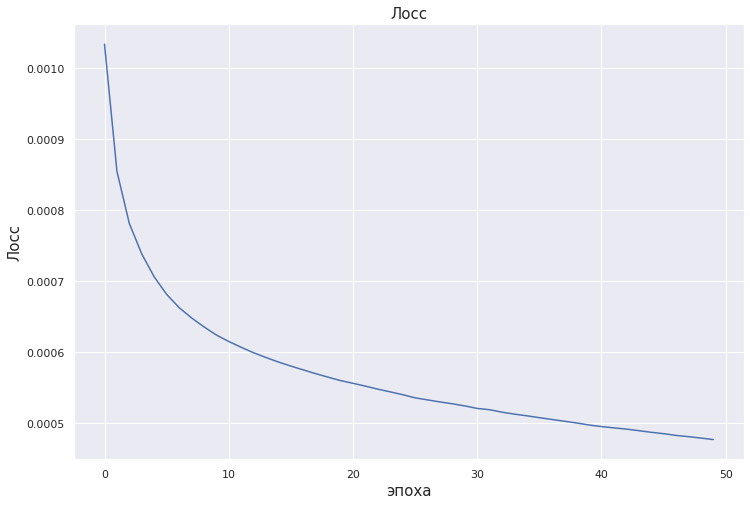

In [226]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.token_to_idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

model, history = train(
    model, loader,
    criterion, optimizer, scheduler, 'plateao',
    num_epochs=50, ylim=None
)

In [0]:
def generate_sample(char_rnn, seed_phrase='i dead', max_length=500, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    seed_phrase = seed_phrase.lower()
    x_sequence = [vocab.token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    result, states = char_rnn(x_sequence[:, :-1])
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        result, states = char_rnn(x_sequence[:, -1].reshape(1, 1), states)
        # Be really careful here with the model output
        p_next = F.softmax(result / temperature, dim=-1).data.detach().cpu().numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, vocab.count)
        next_ix = np.random.choice(vocab.count, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([vocab.idx_to_token[ix] for ix in x_sequence.data.detach().cpu().numpy()[0]])

In [268]:
print(generate_sample(model, seed_phrase='i dead', temperature=0.8))

i dead
  as a worthinuse
  when woe
  o was so i leak if it so concongractift for my gent
  to hate and beauty part are appear
  the good rots
  no or of thy eyes would to sears shade
  thou mist it ous timed with reway
  for that thou dost thou thy sport
  frokn cower
  the brow
  life in lives doth nimpore to death would rememberd forth
  so thou thou red an it impected of fair you save hert
  and i may thy dead than where it with his bear
  dobs shall for my slave
  and could steal feith thy 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [0]:
class VanillaLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_size, num_layers, pad_idx):
        super(VanillaLSTM, self).__init__()

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hid_size = hid_size
        self.n_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(emb_dim, hid_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hid_size, vocab_size)

    def forward(self, inp, states=None):
        out = self.embedding(inp)
        outputs, (hidden, cell) = self.rnn(out, states)
        result = self.linear(outputs)
        return result, (hidden, cell)

In [0]:
model_lstm = VanillaLSTM(vocab.count, 50, 100, 3, vocab.token_to_idx['<pad>']).to(device)

Plot the loss function of the number of epochs. Does the final loss become better?

Epoch 50 of 50 took 1.653s
  loss (in-iteration): 	0.000527


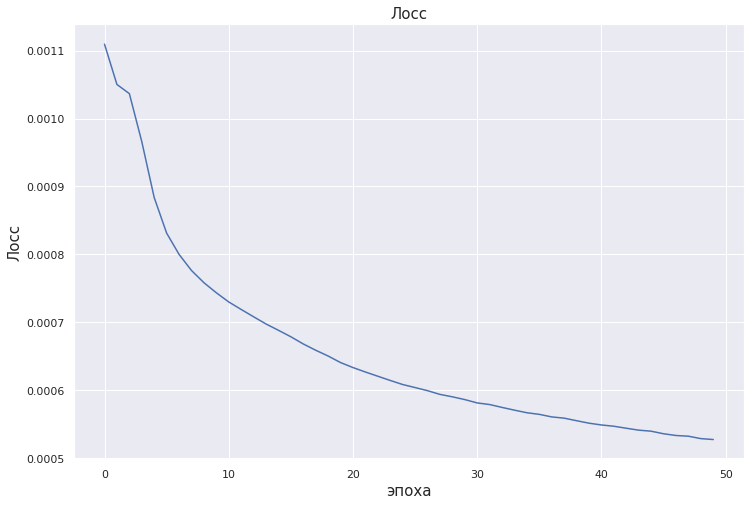

In [281]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.token_to_idx['<pad>'])
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

model_lstm, history = train(
    model_lstm, loader,
    criterion, optimizer, scheduler, 'plateao',
    num_epochs=50, ylim=None
)

По лоссу результаты сопоставимы, но тут он чуть больше.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [290]:
print(generate_sample(model_lstm, seed_phrase='i love you', temperature=1))

i love your will eying is now alruchs
  thint time the to be thy bearry semmpifofed
  noughts the being their hayge lovd end secsed
  with far being tervent in me it wide
  swilt thou outnutiin for my motern
  thine and cray to hhat to me lue tenverned
  if winder wassel doth viyst tenkep have tames tit
  tonguetaoking bemont show loves fave is had
  who more doth best in his waste thy time
  of to reaven bebilesward to strexety
  all he you ring sourante of happale
  outh of fail his mitian and


In [292]:
print(generate_sample(model_lstm, seed_phrase='i love you', temperature=0.7))

i love your barlid not and spender
  the thunk and thought of nutury fair no change
  and love then and cure your his not forth
  o the wind that not my dinces guld
  and in my part for it my life did
  o lest i comon on thou self in is thee
    could in thy summern to that a tonders some
  whereto your may as to my werld to be
    then all that these to beauty she loving
    to it beauty wars in thee reserve triend
  and love that beauty stall of your not her
  that jorn in my preport wroth poo


In [293]:
print(generate_sample(model_lstm, seed_phrase='i love you', temperature=0.3))

i love your with the to should make
    then the will the will so my love thee will
    then and then my love with in dear thee and
  if the there and then and the troughts her
    and there in thee the trome the toul far with
  therefore the men and and there and thee string
  and in thy sun and there stall the dear
  the toul the sun is the beauty shall still
    then all the world of thy beauty what thee
  and therefore the then the trought the fair
  and there and for the treen thee and her



In [295]:
print(generate_sample(model_lstm, seed_phrase='i love you', temperature=0.05))

i love your with the then thee strong
  and therefore the toul the strong thee thee strength
  and there and there and there and thee thee
  and therefore the toul the thought the strong
  and therefore the toul the strong thee thee
  and therefore the toul the toul stall thee
  and there and there in the then thee strength
  and therefore the toul the then thee strong
  and therefore the toul the trought the trought
  and therefore the thought the toul the strong
  and there and there and there


Чем меньше мы делаем `temperature`, тем чаще проскакивают служебные слова, и тем более однообразными становятся предложения.  
С `temperature` около 0.7-1 тексты генерятся довольно хорошие.

Вообще, в сравнении моделей явно выигрывает `LSTM`, это видно даже если просто посмотреть на длину строк, они более равные, как и должно было быть.  
Видимо `LSTM` запомнила информацию о среднем числе символов в строке в оригинале, и поэтому разделяет строки так аккуратно -- это круто.

In [304]:
print(generate_sample(model_lstm, seed_phrase='why am i', temperature=0.8))

why am in love with thoughts hay
  so the such i woldso with live i bell
  the healtencituioms make then lovely digrt
  the world on thy foul still all therefore with
  then row vady steefut it my both ten
  the dair thy beroing of ven and healting
  his your my sugllss mack her will yet didly
  with sinst and comethand with can not slast
  when with beountid part not shast faar
  which the lights of my quiltaled thee
  out thou lovgound me wintent sue some
  shemore how the world art with dedva


И в стихах даже видна рифма иногда.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [305]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !mkdir '/content/gdrive/My Drive/lab3'
path_to_save = '/content/gdrive/My Drive/lab3'

In [0]:
torch.save(model_lstm.state_dict(), path_to_save + 'best_model_ever.pth')

Проверим, что все работает

In [310]:
test_model = VanillaLSTM(vocab.count, 50, 100, 3, vocab.token_to_idx['<pad>']).to(device)
test_model.load_state_dict(torch.load(path_to_save + 'best_model_ever.pth'))

<All keys matched successfully>

In [316]:
print(generate_sample(test_model, seed_phrase='all', temperature=0.8))

ally heart shovers forw
  and in blave that you must sweet comon or priel
    and git a lot sell to thee that balt
  whis thou whose i such still at to gain your
  thy love i solely are worford your sound
  the foremected times worth burder hor
  detreasess do srive cheak of okting frain
  and shall blest thine at that not are sael
    then well old in than in than thou thou irst
  thine bathers not the trull stell my dad
  the king whould now stanvern all counters
  or the oft that beauty reyed


Все работает.  
В заключение скажу, что раз `RNN` модель не смогла запомнить среднюю длину строк в оригинале, это значит, что она уже слабо помнит информацию, которая была ~50-60 символов назад.  
У `LSTM` такой проблемы нет, раз она смогла запомнить.  
Но естественно, она тоже забывает информацию.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)